In [1659]:
# dataframes
import pandas as pd
# numpy
import numpy as np
# plots
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import seaborn as sns
sns.set(font = "serif", style = "whitegrid", palette = "deep", font_scale = 0.75)
# ml models
import statsmodels.api as sm
from statsmodels.compat import lzip
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition  import PLSRegression

Let's do some preliminary analysis.

### sales
1. dimensions of the dataset;
2. data cleaning 	
	1. remove the empty columns and rows;
	2. check for null columns (each entry is `NaN`) / check for null rows;
	3. check types;
	4. `date`:
		- check range;
	5. `is_open`:
		- check is composed by `YES` and `NO` only;
		- edit the exeptions; 
	6. `sales_amount`: 
		- impose `if is_open == "NO" then sales_amount = 0` (and fix exeptions);
		- check if all values are non-negative (NO!);
		- edit negatives and `NaN`;

### market
1. dimensions of the dataset;
2. data cleaning 	
	1. remove the empty columns and rows;
	2. check for null columns (each entry is `NaN`) / check for null rows;
	3. check types;
	4. `id`:
		- unique identifier;
	5. `market_type`:
		- check is composed by correct labels;
	6. `squere_feet`: 
		- check positive; 
	5. `market_type`:
      	- solve `NaN` values;
	6. `avg_customer`: 
		- check positive (and correct);
		- set integer;
	7. `competitor_distance`: 
        - check positive;
	8. `has_promotions`:
		- check is composed by `YES` and `NO` only;

# sales

In [1660]:
sales = pd.read_csv("data/sales.csv")
display(sales)

,market_id,date,is_open,sales_amount,
0,XC14,31/12/2022,YES,55727.34,NaN
1,WG25,31/12/2022,YES,12984.10,NaN
2,UX72,31/12/2022,YES,13046.56,NaN
3,EE84,31/12/2022,YES,60916.76,NaN
4,RF54,31/12/2022,YES,12376.42,NaN
...,...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84,NaN
523945,WW60,01/01/2021,YES,56371.18,NaN
523946,LU14,01/01/2021,YES,24107.19,NaN
523947,HY57,01/01/2021,YES,12257.38,NaN


## 1

dimensions of the dataset

In [1661]:
n_rows_sales = sales.shape[0]
n_cols_sales = sales.shape[1]
print("the number of rows is " + str(n_rows_sales) + " while the number of columns is " + str(n_cols_sales))

the number of rows is 523949 while the number of columns is 5


## 2

### 2.1

In [1662]:
# remove empty colums
sales = sales.dropna(axis = 1, how = "all")
n_cols_sales = sales.shape[1]

# remove empty rows
sales = sales.dropna(axis = 0, how = "all")
n_rows_sales = sales.shape[0]
	
display(sales)

,market_id,date,is_open,sales_amount
0,XC14,31/12/2022,YES,55727.34
1,WG25,31/12/2022,YES,12984.10
2,UX72,31/12/2022,YES,13046.56
3,EE84,31/12/2022,YES,60916.76
4,RF54,31/12/2022,YES,12376.42
...,...,...,...,...
523944,ZM74,01/01/2021,YES,21553.84
523945,WW60,01/01/2021,YES,56371.18
523946,LU14,01/01/2021,YES,24107.19
523947,HY57,01/01/2021,YES,12257.38


### 2.2

check for NaN

In [1663]:
n_nan = sales.isnull().sum().sum()
print("the total number of NaN is " + str(n_nan) + "\n")

print("the number of NaN in each column of sales is:")
for index in range(0, n_cols_sales):
	col = sales.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("- " + sales.columns[index] + " = " + str(n_nan_col))

the total number of NaN is 14

the number of NaN in each column of sales is:
- market_id = 0
- date = 0
- is_open = 0
- sales_amount = 14


(commento) siccome i NaN sono solo in sales_amount bisogna capire come trattarli

### 2.3


check types

In [1664]:
sales.dtypes

market_id        object
date             object
is_open          object
sales_amount    float64
dtype: object

### 2.4

check range of date

In [1665]:
sales["date"] = pd.to_datetime(sales["date"], format = "%d/%m/%Y")
start_date = "01/01/2021"
end_date = "31/12/2022"

# boolean panda's series: True if the date is acceptable (inside the range), False otherwise
check_date_range = sales["date"].between(start_date, end_date)

n_date_out_of_range = n_rows_sales - check_date_range.sum()
print("the number of dates out of range is " + str(n_date_out_of_range))

the number of dates out of range is 0


### 2.5

check is_open is compesed only by yes and no

In [1666]:
# boolean panda's series: True if is_open is acceptable ("YES" or "NO"), False otherwise
check_is_open = sales[~sales["is_open"].isin(["YES", "NO"])].index
print("the rows with no YES or NO in is_open are: " + str(list(check_is_open)))

display(sales.loc[check_is_open, :])

the rows with no YES or NO in is_open are: [49154]


,market_id,date,is_open,sales_amount
49154,BT51,2022-10-14,YESS,25220.48


(commento)

In [1667]:
sales.loc[check_is_open[0], "is_open"] = "YES"

### 2.6

controlliamo che i NO abbiano sales_amount uguale a 0 e li correggiamo

In [1668]:
# sales dataframe restricted to the condition is_open == "NO" with non-acceptable sales_amounts (!= 0)
sales_amount_no_error = sales[(sales["is_open"] == "NO") & (sales["sales_amount"] != 0)]
print("indexes where is_open is NO and sales_amount is not 0: " + str(list(sales_amount_no_error.index)))
sales.loc[sales_amount_no_error.index, "sales_amount"] = 0

indexes where is_open is NO and sales_amount is not 0: [753]


In [1669]:
# sales dataframe restricted to the condition sales_amounts < 0
sales_amount_negative = sales[sales["sales_amount"] < 0]
sales_amount_negative

,market_id,date,is_open,sales_amount
47528,XC14,2022-10-16,YES,-999999.0
48150,XC14,2022-10-15,YES,-999999.0
48772,XC14,2022-10-14,YES,-999999.0
49394,XC14,2022-10-13,YES,-999999.0
50016,XC14,2022-10-12,YES,-999999.0
50638,XC14,2022-10-11,YES,-999999.0


trattiamo i dati negativi e NaN allo stesso modo: sostituiamo il valore con la media dei sales_amount dello stesso market <br>
(commento: altra opzione sarebbe mettere media sullo stesso giorno con market dello stesso tipo nello stessa nazione)

correcting errors: we iterate over the non-acceptable rows of the sales dataframe, subsituting the wrong sales_amounts with the previously computed mean

In [1670]:
# sales dataframe restricted to the rows with non-acceptable sales_amounts (NaN or negative values)
sales_amount_error = sales[sales["sales_amount"].isnull() | (sales["sales_amount"] < 0)]
display(sales_amount_error)

# dataframe containing the market_id's and their correspondent mean sales_amount
mean_sales_amount = (sales[(sales["sales_amount"] > 0)].groupby("market_id"))["sales_amount"].mean()

# correcting errors
for index, row in (sales.loc[sales_amount_error.index]).iterrows():
	sales.loc[index, "sales_amount"] = mean_sales_amount[row["market_id"]]
# portion of the dataframe corrected
sales.loc[sales_amount_error.index]

,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,NaN
47528,XC14,2022-10-16,YES,-999999.0
48150,XC14,2022-10-15,YES,-999999.0
48772,XC14,2022-10-14,YES,-999999.0
49394,XC14,2022-10-13,YES,-999999.0
50016,XC14,2022-10-12,YES,-999999.0
50638,XC14,2022-10-11,YES,-999999.0
174088,UF73,2022-04-12,YES,NaN
223239,BY57,2022-02-05,YES,NaN
509998,NL22,2021-01-19,YES,NaN


,market_id,date,is_open,sales_amount
98,OG21,2022-12-31,YES,62768.862528
47528,XC14,2022-10-16,YES,60603.900400
48150,XC14,2022-10-15,YES,60603.900400
48772,XC14,2022-10-14,YES,60603.900400
49394,XC14,2022-10-13,YES,60603.900400
50016,XC14,2022-10-12,YES,60603.900400
50638,XC14,2022-10-11,YES,60603.900400
174088,UF73,2022-04-12,YES,12005.331014
223239,BY57,2022-02-05,YES,12628.222322
509998,NL22,2021-01-19,YES,12017.349917


# market

In [1671]:
market = pd.read_csv("data/market.csv")
display(market)

,id,country,Unnamed: 2,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,NaN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,NaN,MINI,1402,252.0,522,YES
2,UX72,FRANCE,NaN,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,NaN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,NaN,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...,...
745,ZM74,ITALY,NaN,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,NaN,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,NaN,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,NaN,MINI,2495,228.0,3848,YES


## 1

dimensions of the dataset

In [1672]:
n_rows_market = market.shape[0]
n_cols_market = market.shape[1]
print("the number of rows is " + str(n_rows_market) + " while the number of columns is " + str(n_cols_market))

the number of rows is 750 while the number of columns is 8


## 2

### 2.1

In [1673]:
# remove empty colums
market = market.dropna(axis = 1, how = "all")
n_cols_market = market.shape[1]

# remove empty rows
market = market.dropna(axis = 0, how = "all")
n_rows_market = market.shape[0]
	
display(market)

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,XC14,SPAIN,HYPER,11135,773.0,515,YES
1,WG25,FRANCE,MINI,1402,252.0,522,YES
2,UX72,FRANCE,MINI,1452,265.0,15939,YES
3,EE84,SPAIN,HYPER,15259,874.0,754,YES
4,RF54,FRANCE,MINI,2497,191.0,34007,YES
...,...,...,...,...,...,...,...
745,ZM74,ITALY,SUPER,5778,356.0,4424,YES
746,WW60,FRANCE,HYPER,10923,907.0,41359,YES
747,LU14,ITALY,SUPER,5742,397.0,2841,YES
748,HY57,ITALY,MINI,2495,228.0,3848,YES


### 2.2

check for NaN

In [1674]:
n_nan = market.isnull().sum().sum()
print("the total number of NaN is " + str(n_nan) + "\n")

print("the number of NaN in each column of market is:")
for index in range(0, n_cols_market):
	col = market.iloc[:, index]
	n_nan_col = col.isnull().sum().sum()
	print("- " + market.columns[index] + " = " + str(n_nan_col))

the total number of NaN is 3

the number of NaN in each column of market is:
- id = 0
- country = 0
- market_type = 2
- square_feet = 0
- avg_customers = 1
- competitor_distance = 0
- has_promotions = 0


### 2.3

In [1675]:
market.dtypes

id                      object
country                 object
market_type             object
square_feet              int64
avg_customers          float64
competitor_distance      int64
has_promotions          object
dtype: object

c'è un problema: avg_customers è float, invece noi lo si vuole int. Gli altri tipi vanno bene

### 2.4

In [1676]:
print("the market id's are unique:", len(market) == len(pd.unique(market["id"])))

the market id's are unique: True


### 2.5

check market_type is compesed only by correct labels

In [1677]:
# boolean panda's series: True if market_type is acceptable ("MINI", "SUPER" or "HYPER"), False otherwise
check_market_type = market[~market["market_type"].isin(["MINI", "SUPER", "HYPER"])].index
print("the rows with non correct labels are: " + str(list(check_market_type)))

display(market.loc[check_market_type, :])

the rows with non correct labels are: [90, 225]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,NaN,14305,637.0,1701,YES
225,KB10,ITALY,NaN,1520,150.0,479,YES


### 2.6

In [1678]:
# boolean panda's series: True if square_feet is positive, False otherwise
check_square_feet = market[market["square_feet"] <= 0].index
print("the rows with negative square_feet are: " + str(list(check_square_feet)))

the rows with negative square_feet are: []


### 2.7

In [1679]:
# market without uncorrect market_type 
market_correct = market.iloc[~market.index.isin(check_market_type)]

# dataframe containing the country, the market_type and their correspondent mean square_feet
mean_sqfeet_bycountry = (market_correct.groupby(["country", "market_type"]))["square_feet"].mean()
display(pd.DataFrame(mean_sqfeet_bycountry))

square_feet
country market_type              
FRANCE  HYPER        12153.225806
        MINI          1998.402778
        SUPER         6035.285714
ITALY   HYPER        12052.172414
        MINI          2054.526786
        SUPER         6067.655172
SPAIN   HYPER        12063.774194
        MINI          1978.367089
        SUPER         6079.606061

tra le nazioni le medie degli square_feet non sono particolarmente diverse (per market_type)

correcting errors: we iterate over the non-acceptable rows of the market dataframe, subsituting the NaN values with the market type corresponding with the closest (in terms of square_feet) market_type in the same country

In [1680]:
# correcting errors
for index, row in market.loc[check_market_type, :].iterrows():
	# panda's series with the square_feet means with respect to market_type in the country row["country"]
	mean_sqfeet_country = mean_sqfeet_bycountry[row["country"]]
	# closest square_feet value within the previous pandas series
	closest_sqfeet = min(mean_sqfeet_country, key = lambda x: abs(row["square_feet"] - x))
	# corresponding market_type
	closest_market_type = (mean_sqfeet_country[mean_sqfeet_country == closest_sqfeet]).index[0]
	# assigning the market_type
	market.loc[index, "market_type"] = closest_market_type

# corrected rows
display(market.loc[check_market_type, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
90,RU30,SPAIN,HYPER,14305,637.0,1701,YES
225,KB10,ITALY,MINI,1520,150.0,479,YES


abbiamo mostrato con un loop come modificare i dati errati sebbene fossero solo 2, in quanto in contesti generici sarebbero potuti essere decine o centinaia i valori mancanti

### 2.8

In [1681]:
# boolean panda's series: True if avg_customers is acceptable (not NaN or negative), False otherwise
check_avg_customers = market[market["avg_customers"].isnull() | (market["avg_customers"] < 0)].index
print("the rows with non acceptable values are: " + str(list(check_avg_customers)))

display(market.loc[check_avg_customers, :])

the rows with non acceptable values are: [69, 626]


,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,-9999.0,6281,YES
626,OD40,ITALY,HYPER,14157,NaN,3519,YES


(stessa roba di prima, non necessita commenti)

In [1682]:
market_correct = market.iloc[~market.index.isin(check_avg_customers)]
mean_avgcust_bycountry = (market_correct.groupby(["country", "market_type"]))["avg_customers"].mean()
display(pd.DataFrame(mean_avgcust_bycountry))

for index, row in market.loc[check_avg_customers, :].iterrows():
	market.loc[index, "avg_customers"] = mean_avgcust_bycountry[row["country"]][row["market_type"]]

display(market.loc[check_avg_customers, :])

avg_customers
country market_type               
FRANCE  HYPER           688.258065
        MINI            210.527778
        SUPER           401.396825
ITALY   HYPER           733.785714
        MINI            208.646018
        SUPER           401.293103
SPAIN   HYPER           763.483871
        MINI            214.329114
        SUPER           405.333333

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763.483871,6281,YES
626,OD40,ITALY,HYPER,14157,733.785714,3519,YES


tra le nazioni le medie degli avg_customers non sono particolarmente diverse (per market_type)

In [1683]:
market["avg_customers"] = market["avg_customers"].round().astype('int')
display(market.loc[check_avg_customers, :])

,id,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
69,IP89,SPAIN,HYPER,15560,763,6281,YES
626,OD40,ITALY,HYPER,14157,734,3519,YES


### 2.9

In [1684]:
# boolean panda's series: True if competitor_distance is positive, False otherwise
check_competitor_distance = market[market["competitor_distance"] <= 0].index
print("the rows with negative competitor_distance are: " + str(list(check_square_feet)))

the rows with negative competitor_distance are: []


### 2.10

In [1685]:
# boolean panda's series: True if has_promotions is acceptable ("YES" or "NO"), False otherwise
check_has_promotions = market[~market["has_promotions"].isin(["YES", "NO"])].index
print("the rows with non correct values are: " + str(list(check_has_promotions)))

# display(market.loc[check_has_promotions, :])

the rows with non correct values are: []


# dataset

## build dataset

collapse temporal information of sales

In [1686]:
sales["is_open"] = sales["is_open"].map({"YES": 1, "NO": 0})
is_open = sales.groupby("market_id")["is_open"].mean().reset_index()
sales_amount = sales[sales["is_open"] == 1].groupby("market_id")["sales_amount"].mean().reset_index()
sales = pd.merge(is_open, sales_amount, on = "market_id")
display(sales)

,market_id,is_open,sales_amount
0,AA39,0.827397,12609.579520
1,AA82,0.820513,26573.814219
2,AB90,0.830137,26124.283769
3,AC71,0.820513,11856.326518
4,AD13,0.824658,12392.551096
...,...,...,...
745,ZX46,0.830137,12570.549505
746,ZX76,0.820513,12375.246473
747,ZY62,0.827397,26404.851308
748,ZZ11,0.818681,12542.256577


merge datasets

In [1687]:
merged_df = pd.merge(sales, market, left_on = "market_id", right_on = "id", how = "left").drop(["market_id", "id"], axis = 1)
merged_df

,is_open,sales_amount,country,market_type,square_feet,avg_customers,competitor_distance,has_promotions
0,0.827397,12609.579520,FRANCE,MINI,2437,248,58,YES
1,0.820513,26573.814219,FRANCE,SUPER,6403,493,300,YES
2,0.830137,26124.283769,FRANCE,SUPER,7544,340,1598,YES
3,0.820513,11856.326518,SPAIN,MINI,1940,165,2068,YES
4,0.824658,12392.551096,FRANCE,MINI,1486,166,750,YES
...,...,...,...,...,...,...,...,...
745,0.830137,12570.549505,FRANCE,MINI,1691,272,1843,YES
746,0.820513,12375.246473,FRANCE,MINI,1462,159,547,YES
747,0.827397,26404.851308,FRANCE,SUPER,5946,488,2743,YES
748,0.818681,12542.256577,FRANCE,MINI,1413,239,1920,YES


## data_visualization

### boxplots

boxplots of quantitative variables

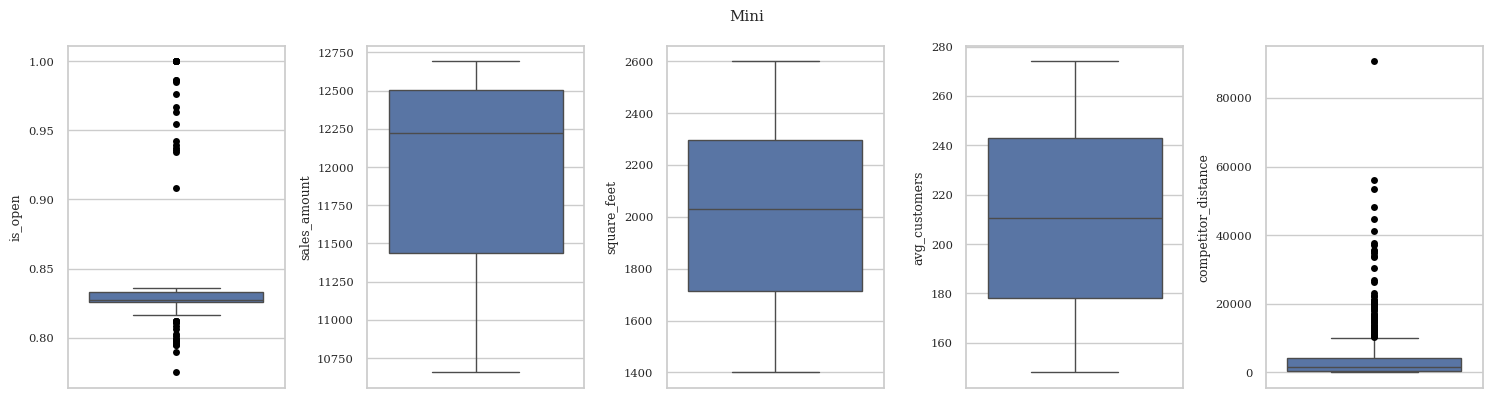

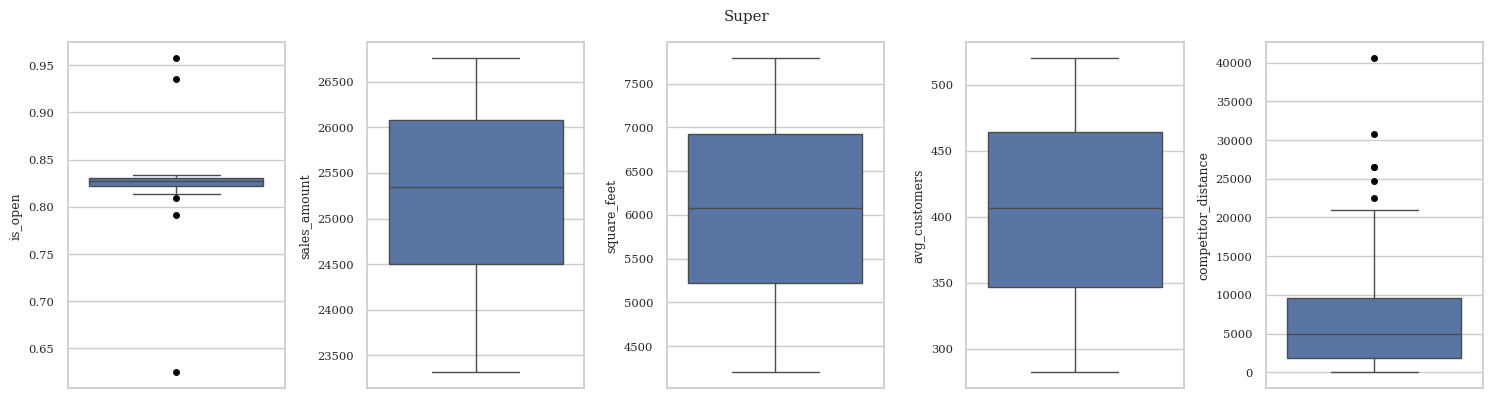

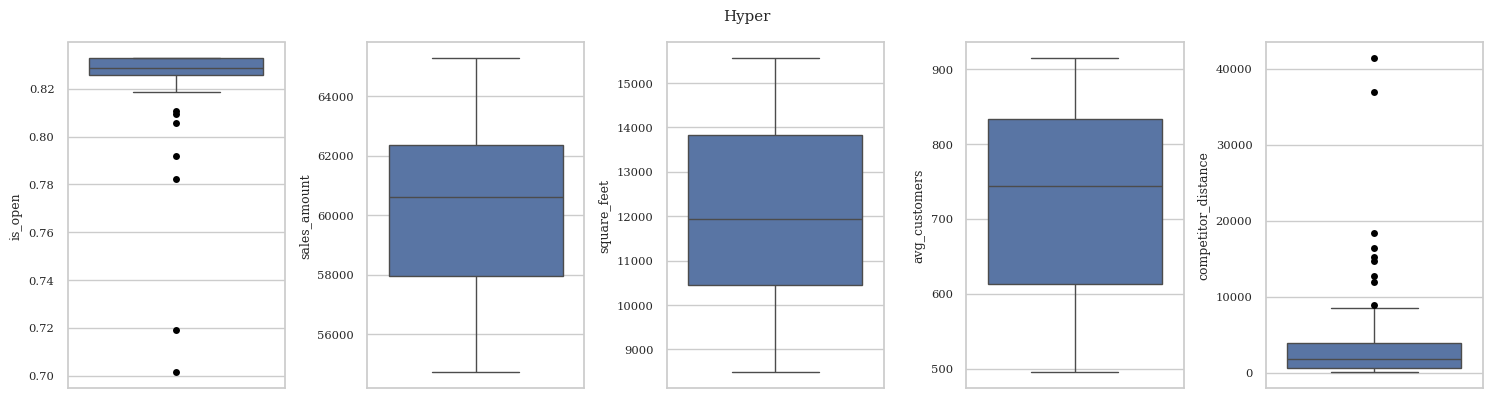

In [1688]:
quant_names = ["is_open", "sales_amount", "square_feet", "avg_customers", "competitor_distance"]
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type]

	fig, ax = plt.subplots(ncols = 5, nrows = 1, figsize = (15, 4))
	ax = ax.flatten()
	index = 0
	for col_name in quant_names:
		sns.boxplot(y = col_name, data = merged_df_mt, ax = ax[index],
			flierprops = {"marker": ".", "markersize": 10, "markerfacecolor": "black", "markeredgecolor": "none"})
		index += 1
	fig.suptitle(market_type.title())
	plt.tight_layout()
	plt.show()

It seems there are some outliers, let's see the outlier percentage per column. <br>
To check outliers (before fitting the model), one standard approach is to compute the `iqr` (interquartile range) and then check values that are:
- lower than $\text{quantile}(0.25) - 1.5 \cdot \text{iqr}$  or
- greater than $\text{quantile}(0.75) + 1.5 \cdot \text{iqr}$.

In [1689]:
for market_type in pd.unique(merged_df["market_type"]):
	merged_df_mt = merged_df[merged_df["market_type"] == market_type].drop("market_type", axis = 1)
	
	print(str(market_type.title()) + ":")
	for col_name, col in merged_df_mt[quant_names].items():
		q1 = col.quantile(0.25)
		q3 = col.quantile(0.75)
		iqr = q3 - q1
		outliers_col = col[(col <= q1 - 1.5 * iqr) | (col >= q3 + 1.5 * iqr)]
		print("\t - " + col_name + ": " + str(round(len(outliers_col) / len(col) * 100, 2)) + "%")

Mini:
	 - is_open: 10.54%
	 - sales_amount: 0.0%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 15.2%
Super:
	 - is_open: 2.0%
	 - sales_amount: 0.0%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 2.4%
Hyper:
	 - is_open: 7.61%
	 - sales_amount: 0.0%
	 - square_feet: 0.0%
	 - avg_customers: 0.0%
	 - competitor_distance: 9.78%


### countplots

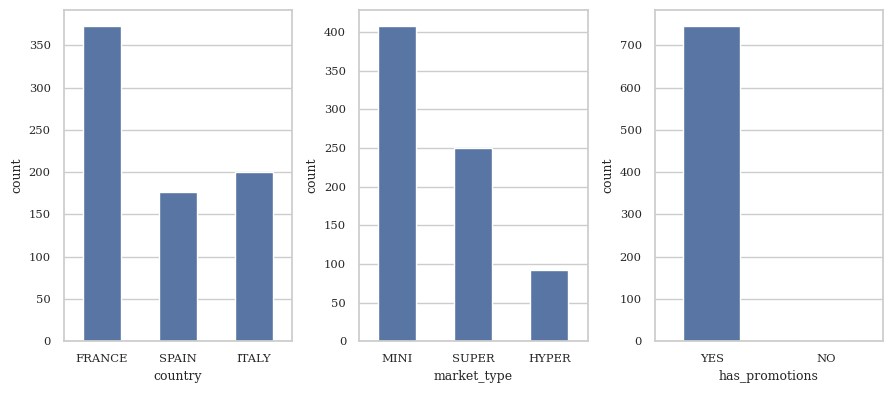

In [1690]:
cat_names = ["country", "market_type", "has_promotions"]
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (9, 4))
index = 0
ax = ax.flatten()
for col_name in cat_names:
	sns.countplot(x = col_name, data = merged_df, ax = ax[index], width = 0.5)
	index += 1
plt.tight_layout()

In [1691]:
len(merged_df[merged_df["has_promotions"] == "NO"])

4

### ecode categorical variables

encode categorical variables

In [1692]:
# split country and market_type
merged_df = pd.concat([merged_df, merged_df["country"].rename("is_france"), merged_df["country"].rename("is_italy"),
	merged_df["market_type"].rename("is_super"), merged_df["market_type"].rename("is_hyper")], axis = 1)
merged_df.rename(columns = {"country": "is_spain", "market_type": "is_mini"}, inplace = True)
merged_df = merged_df[["sales_amount", "is_open", "is_spain", "is_france", "is_italy", "is_mini", "is_super", "is_hyper",
	"square_feet", "avg_customers", "competitor_distance", "has_promotions"]]

# country
merged_df["is_spain"] = merged_df["is_spain"].map({"SPAIN": 1, "FRANCE": 0, "ITALY": 0})
merged_df["is_france"] = merged_df["is_france"].map({"SPAIN": 0, "FRANCE": 1, "ITALY": 0})
merged_df["is_italy"] = merged_df["is_italy"].map({"SPAIN": 0, "FRANCE": 0, "ITALY": 1})

# market_type
merged_df["is_mini"] = merged_df["is_mini"].map({"MINI": 1, "SUPER": 0, "HYPER": 0})
merged_df["is_super"] = merged_df["is_super"].map({"MINI": 0, "SUPER": 1, "HYPER": 0})
merged_df["is_hyper"] = merged_df["is_hyper"].map({"MINI": 0, "SUPER": 0, "HYPER": 1})

# has_promotions
merged_df["has_promotions"] = merged_df["has_promotions"].map({"YES": 1, "NO": 0})

display(merged_df)

,sales_amount,is_open,is_spain,is_france,is_italy,is_mini,is_super,is_hyper,square_feet,avg_customers,competitor_distance,has_promotions
0,12609.579520,0.827397,0,1,0,1,0,0,2437,248,58,1
1,26573.814219,0.820513,0,1,0,0,1,0,6403,493,300,1
2,26124.283769,0.830137,0,1,0,0,1,0,7544,340,1598,1
3,11856.326518,0.820513,1,0,0,1,0,0,1940,165,2068,1
4,12392.551096,0.824658,0,1,0,1,0,0,1486,166,750,1
...,...,...,...,...,...,...,...,...,...,...,...,...
745,12570.549505,0.830137,0,1,0,1,0,0,1691,272,1843,1
746,12375.246473,0.820513,0,1,0,1,0,0,1462,159,547,1
747,26404.851308,0.827397,0,1,0,0,1,0,5946,488,2743,1
748,12542.256577,0.818681,0,1,0,1,0,0,1413,239,1920,1


### scatterplot

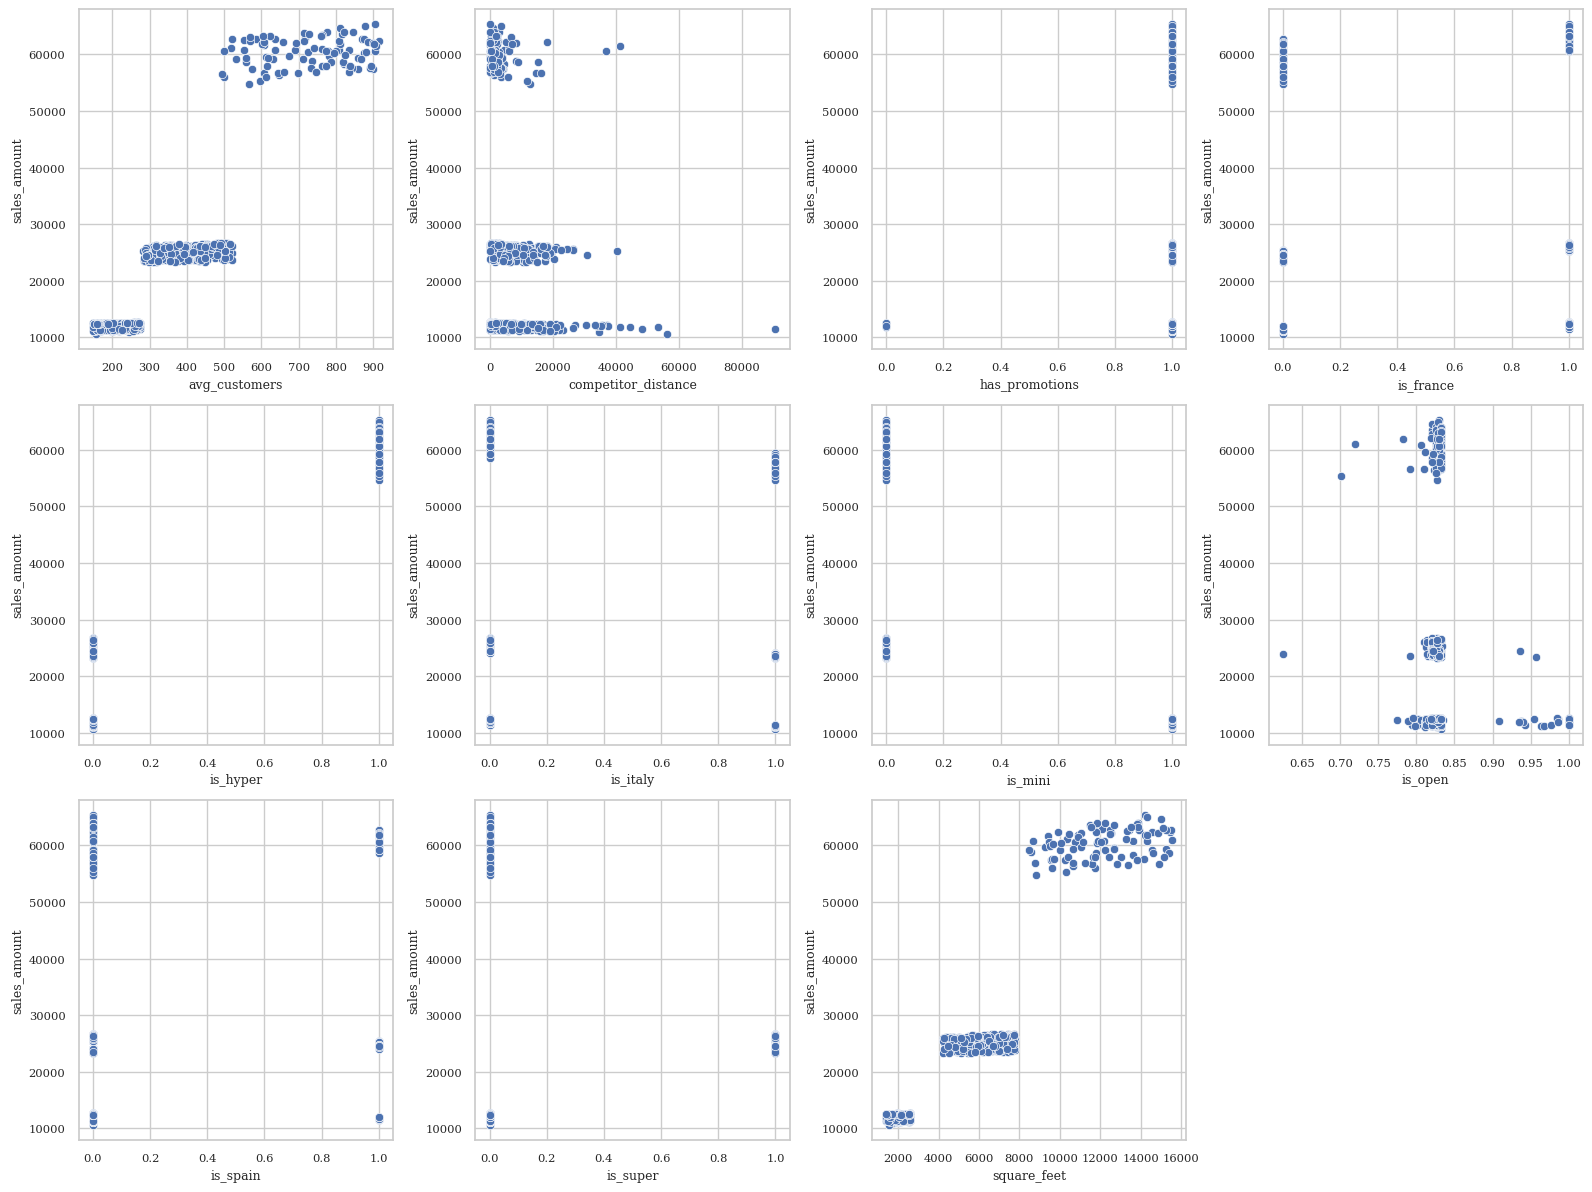

In [1693]:
fig, ax = plt.subplots(ncols = 4, nrows = 3, figsize = (16, 12))
index = 0
ax = ax.flatten()
for col_name in merged_df.columns.difference(["sales_amount"]):
	current_plot = sns.scatterplot(y = merged_df["sales_amount"], x = merged_df[col_name], ax = ax[index])
	index = index + 1
ax[-1].axis("off")
plt.tight_layout()

### correlation matrix

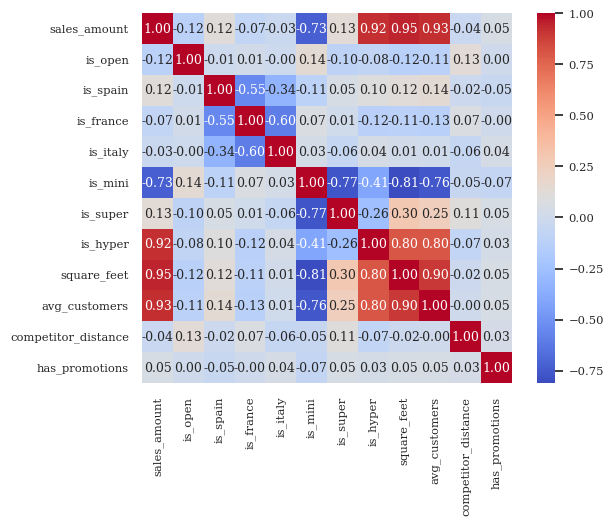

In [1694]:
ax = sns.heatmap(merged_df.corr(), annot = True, cmap = "coolwarm", fmt = ".2f", square = True)
ax.tick_params(left = False, bottom = False)

# fit linear model

In [1695]:
merged_df

,sales_amount,is_open,is_spain,is_france,is_italy,is_mini,is_super,is_hyper,square_feet,avg_customers,competitor_distance,has_promotions
0,12609.579520,0.827397,0,1,0,1,0,0,2437,248,58,1
1,26573.814219,0.820513,0,1,0,0,1,0,6403,493,300,1
2,26124.283769,0.830137,0,1,0,0,1,0,7544,340,1598,1
3,11856.326518,0.820513,1,0,0,1,0,0,1940,165,2068,1
4,12392.551096,0.824658,0,1,0,1,0,0,1486,166,750,1
...,...,...,...,...,...,...,...,...,...,...,...,...
745,12570.549505,0.830137,0,1,0,1,0,0,1691,272,1843,1
746,12375.246473,0.820513,0,1,0,1,0,0,1462,159,547,1
747,26404.851308,0.827397,0,1,0,0,1,0,5946,488,2743,1
748,12542.256577,0.818681,0,1,0,1,0,0,1413,239,1920,1


## feature selection

best model:
	- k = 7 
	- model = ['square_feet', 'is_hyper', 'is_super', 'is_italy', 'is_spain', 'avg_customers', 'competitor_distance']
best metrics:
	- RSE: 650.9904643060594
	- R2: 0.9982955947083116
	- MSE: 404002.961247275


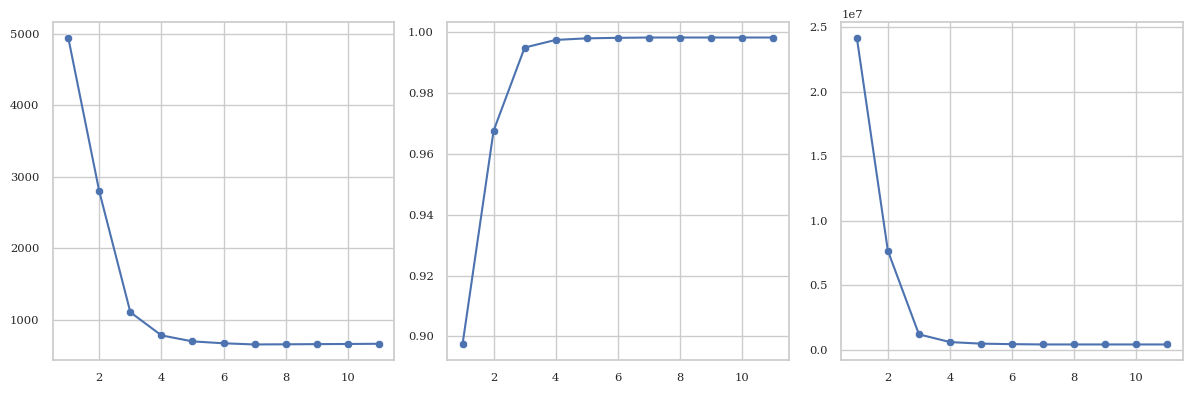

In [1696]:
# define a function to calculate RSE, R2, and MSE
def calculate_metrics(y_test, y_pred, p):
	residuals = y_test - y_pred
	RSE = (sum(residuals ** 2) / (len(residuals) - p - 1)) ** 0.5
	R2 = 1 - sum(residuals ** 2) / sum((y_test - y_test.mean()) ** 2)
	MSE = (residuals ** 2).mean()
	return RSE, R2, MSE

def better_by_criteria(value_1, value_2, criteria):
	if (criteria == "RSE") or (criteria == "MSE"):
		return (value_1 < value_2)
	elif (criteria == "R2"):
		return (value_1 > value_2)

# forward selection
def forward_selection_v2(X, y, criteria):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)
	
	# initialize parameters
	p = X.shape[1]
	best_features = [[]] * p
	best_metrics_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	best_metrics = []
	for _ in range(p):
		best_metrics.append(best_metrics_k.copy())
	current_features = []
	remaining_features = list(X.columns)
	
	# for each number of features
	for k in range(0, p):
		# for each combination of k number of features
		for new_feature in remaining_features:
			model_features = current_features + [new_feature]
			X_subset = X[model_features]
			# add a constant for the intercept term
			X_subset = sm.add_constant(X_subset)  
			# initialize empty array to store mse for each fold
			cv_folds = {
				"RSE": 0,
				"R2": 0,
				"MSE": 0,
				"len": 0
			}
			# for each fold fit the model and estimate cv test error (using the mean of MSE in all folds)
			for train_index, validation_index in kf.split(X_subset):
				X_train, X_validation = X_subset.iloc[train_index], X_subset.iloc[validation_index]
				y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
				model = sm.OLS(y_train, X_train).fit()
				y_pred = model.predict(X_validation)
				RSE, R2, MSE = calculate_metrics(y_validation, y_pred, k + 1)
				cv_folds["RSE"] = cv_folds["RSE"] + RSE
				cv_folds["R2"] = cv_folds["R2"] + R2
				cv_folds["MSE"] = cv_folds["MSE"] + MSE
				cv_folds["len"] = cv_folds["len"] + 1
			cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
			# if the estimation of the test error is reduced, save metrics and model
			if better_by_criteria(cv_folds[criteria], best_metrics[k][criteria], criteria):
				best_metrics[k]["RSE"] = cv_folds["RSE"]
				best_metrics[k]["R2"] = cv_folds["R2"]
				best_metrics[k]["MSE"] = cv_folds["MSE"]
				best_features[k] = model_features
		current_features = best_features[k]
		remaining_features = list(set(remaining_features) - set(current_features))
	return best_features, best_metrics

def plot_best_model(best_metrics):
	p = len(best_metrics)
	_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
	index = 0
	ax = ax.flatten()
	for error_type in ["RSE", "R2", "MSE"]:
		error_list = [best_metrics[k][error_type] for k in range(p)]
		sns.lineplot(x = range(1, p + 1), y = error_list, ax = ax[index])
		sns.scatterplot(x = range(1, p + 1), y = error_list, ax = ax[index])
		index = index + 1
	plt.tight_layout()

def report_best_parameters(best_features, best_metrics, criteria):
	p = len(best_metrics)
	criteria_list = [best_metrics[k][criteria] for k in range(p)]
	if (criteria == "RSE") or (criteria == "MSE"):
		criteria_best_k = criteria_list.index(min(criteria_list))
	elif (criteria == "R2"):
		criteria_best_k = criteria_list.index(max(criteria_list))
	print("best model:\n\t- k =", criteria_best_k + 1, "\n\t- model =", best_features[criteria_best_k])
	print("best metrics:\n\t- RSE:", best_metrics[criteria_best_k]["RSE"])
	print("\t- R2:", best_metrics[criteria_best_k]["R2"])
	print("\t- MSE:", best_metrics[criteria_best_k]["MSE"])
	return best_features[criteria_best_k]

# load the dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = merged_df["sales_amount"]

# calculate and display the results
criteria = "RSE"
best_features, best_metrics = forward_selection_v2(X, y, criteria)
best_features = report_best_parameters(best_features, best_metrics, criteria)
plot_best_model(best_metrics)

In [1697]:
# split in train and test
X = merged_df[best_features]
y = merged_df["sales_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# fit the linear regression model
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train_with_intercept).fit()

# model accuracy (RSE, R2 and MSE)
y_pred = model.predict(X_test_with_intercept)
RSE, R2, MSE = calculate_metrics(y_test, y_pred, p = X_train.shape[1])
print("errors:\n\t- RSE:", RSE, "\n\t- R2:", R2, "\n\t- MSE:", MSE)

errors:
	- RSE: 691.7937075177307 
	- R2: 0.9981523042239946 
	- MSE: 453054.3452938671


In [1698]:
# coefficient estimates 
coefficients = model.params

# dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
	row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
	rows.append(row)
summary_coeff = pd.DataFrame(rows, columns = ["", "ols estimation", "SE", "t-stats", "p-value"])
summary_coeff

,,ols estimation,SE,t-stats,p-value
0,const,11683.824462,104.447966,111.862633,0.000000e+00
1,square_feet,0.252251,0.026250,9.609686,2.049059e-20
2,is_hyper,44204.421440,338.522190,130.580573,0.000000e+00
3,is_super,11519.798219,139.338545,82.674885,0.000000e+00
4,is_italy,-2024.963330,60.707696,-33.355958,4.501079e-138
5,is_spain,-917.337600,63.376925,-14.474315,7.173956e-41
6,avg_customers,3.247562,0.387243,8.386374,3.677543e-16
7,competitor_distance,-0.017267,0.003044,-5.673085,2.195835e-08


In [1699]:
# 95% confidence intervals
confidence_intervals = model.conf_int(alpha = 0.05)  # 0.05 for a 95% confidence interval

print("the 95% confidence intervals:")
for index, value in coefficients.items():
    current_conf_int = confidence_intervals.loc[index].values
    print("\t - ",index, "is", current_conf_int)

the 95% confidence intervals:
	 -  const is [11478.69082317 11888.95810152]
	 -  square_feet is [0.20069696 0.30380442]
	 -  is_hyper is [43539.57087881 44869.27200171]
	 -  is_super is [11246.14020472 11793.456233  ]
	 -  is_italy is [-2144.19198566 -1905.73467366]
	 -  is_spain is [-1041.80856546  -792.86663406]
	 -  avg_customers is [2.48702542 4.0080987 ]
	 -  competitor_distance is [-0.02324407 -0.01128898]


### residuals analysis

correlation of error terms

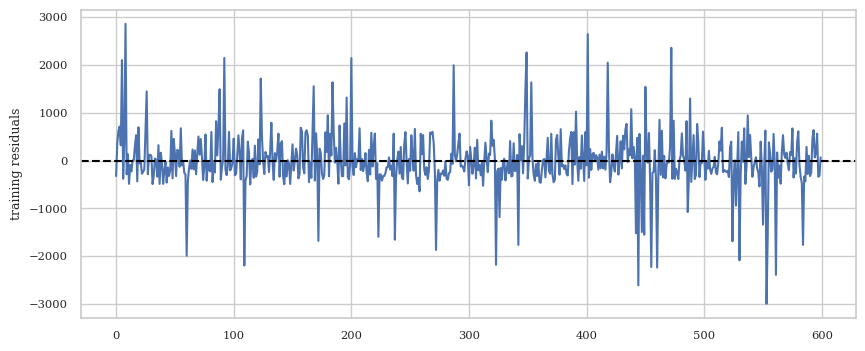

In [1700]:
residuals_training = model.resid

plt.figure(figsize = (10, 4))
fig = sns.lineplot(x = range(0, len(residuals_training)), y = residuals_training)
fig.axhline(0, linestyle = "--", color = "black")
plt.ylabel("training residuals")
plt.show()

In [1701]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)
print("- autocorrelation =", round(autocorrelation, 5), "\n- durbin-watson statistic:", round(durbin_watson, 5))

- autocorrelation = 0.00015 
- durbin-watson statistic: 1.97482


suggesting that error terms are not correlated

In [1702]:
mini_index = merged_df[merged_df["is_mini"] == 1].index
super_index = merged_df[merged_df["is_super"] == 1].index
hyper_index = merged_df[merged_df["is_hyper"] == 1].index
list_index = [mini_index, super_index, hyper_index]
list_names = ["Mini", "Super", "Hyper"]

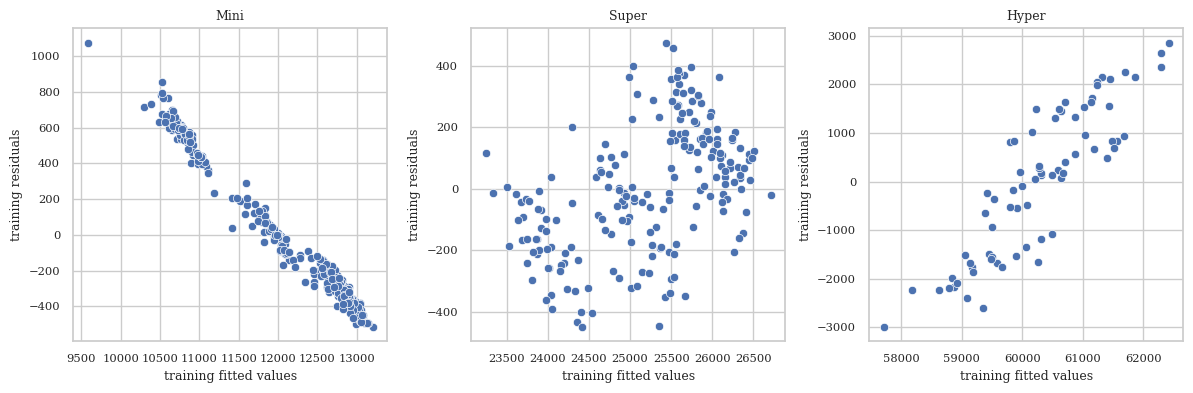

In [1703]:
# variance of error terms: residuals vs fitted values
_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
index = 0
ax = ax.flatten()
for index in range(3):
	remove_indexes = list_index[:index] + list_index[(index + 1):]
	X_train_with_intercept_market = X_train_with_intercept.loc[X_train_with_intercept.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	residuals_training_market = residuals_training.loc[residuals_training.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	sns.scatterplot(x = model.predict(X_train_with_intercept_market), y = residuals_training_market, ax = ax[index])
	ax[index].set_title(list_names[index])
	ax[index].set_xlabel("training fitted values")
	ax[index].set_ylabel("training residuals")
	index = index + 1
plt.tight_layout()

In [1704]:
name = ["lagrange multiplier statistic", "p-value"]
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
print("- lagrange multiplier statistic:", lzip(name, test)[0][1], "\n- p-value", lzip(name, test)[1][1])

- lagrange multiplier statistic: 320.6528343630137 
- p-value 2.3379788581370095e-65


### Collinearity

In [1705]:
# collinearity
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Feature"] = X_train.columns
vif

,VIF Factor,Feature
0,27.739075,square_feet
1,8.027954,is_hyper
2,5.330583,is_super
3,1.518555,is_italy
4,1.516520,is_spain
5,15.369061,avg_customers
6,1.446404,competitor_distance


## log of target

best model:
	- k = 7 
	- model = ['square_feet', 'is_mini', 'is_hyper', 'is_italy', 'is_france', 'competitor_distance', 'avg_customers']
best metrics:
	- RSE: 0.002444451154390227
	- R2: 0.999981294166683
	- MSE: 5.705157292063723e-06


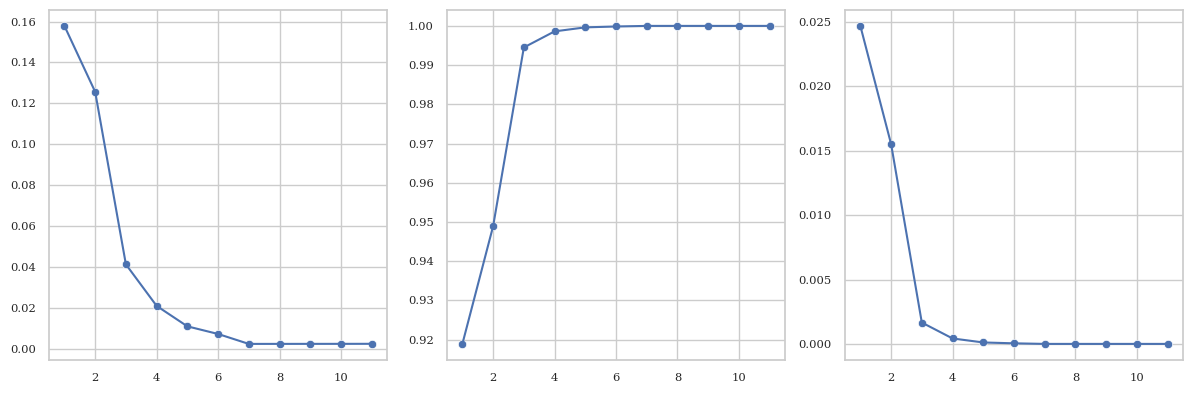

In [1706]:
# feature selection
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = np.log(merged_df["sales_amount"])

criteria = "RSE"
best_models, best_metrics = forward_selection_v2(X, y, criteria)
best_features = report_best_parameters(best_models, best_metrics, criteria)
plot_best_model(best_metrics)

In [1707]:
# split in train and test
X = merged_df[best_features]
y = np.log(merged_df["sales_amount"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# fit the linear regression model
X_train_with_intercept = sm.add_constant(X_train)
X_test_with_intercept = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train_with_intercept).fit()

# model accuracy (RSE, R2 and MSE)
y_pred = model.predict(X_test_with_intercept)
RSE, R2, MSE = calculate_metrics(y_test, y_pred, p = X_train.shape[1])
print("errors:\n\t- RSE:", RSE, "\n\t- R2:", R2, "\n\t- MSE:", MSE)

errors:
	- RSE: 0.002828876372998247 
	- R2: 0.9999756606456272 
	- MSE: 7.575739318576644e-06


In [1708]:
# coefficient estimates 
coefficients = model.params

# dataframe with all coefficients and stats of interest 
rows = []
for index, value in coefficients.items():
	row = [index, value, model.bse[index], model.tvalues[index], model.pvalues[index]]
	rows.append(row)
summary_coeff = pd.DataFrame(rows, columns = ["", "ols estimation", "SE", "t-stats", "p-value"])
summary_coeff

,,ols estimation,SE,t-stats,p-value
0,const,10.052211,8.571120e-04,11728.000985,0.000000e+00
1,square_feet,0.000006,9.773689e-08,60.035177,6.160362e-254
2,is_mini,-0.695367,5.188079e-04,-1340.317502,0.000000e+00
3,is_hyper,0.811897,8.132052e-04,998.390979,0.000000e+00
4,is_italy,-0.048913,2.649698e-04,-184.596554,0.000000e+00
5,is_france,0.046333,2.359753e-04,196.347407,0.000000e+00
6,competitor_distance,-0.000001,1.133238e-08,-90.450243,0.000000e+00
7,avg_customers,0.000103,1.441845e-06,71.500338,2.044890e-293


In [1709]:
# 95% confidence intervals
confidence_intervals = model.conf_int(alpha = 0.05)  # 0.05 for a 95% confidence interval

print("the 95% confidence intervals:")
for index, value in coefficients.items():
    current_conf_int = confidence_intervals.loc[index].values
    print("\t - ",index, "is", current_conf_int)

the 95% confidence intervals:
	 -  const is [10.05052738 10.05389408]
	 -  square_feet is [5.67569842e-06 6.05960488e-06]
	 -  is_mini is [-0.6963863  -0.69434844]
	 -  is_hyper is [0.81029965 0.81349388]
	 -  is_italy is [-0.04943292 -0.04839213]
	 -  is_france is [0.04586968 0.04679658]
	 -  competitor_distance is [-1.04727284e-06 -1.00275973e-06]
	 -  avg_customers is [0.00010026 0.00010592]


### residual analysis

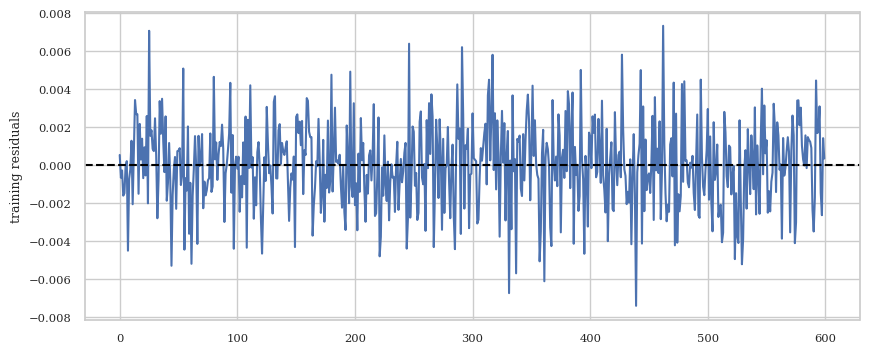

In [1710]:
residuals_training = model.resid

plt.figure(figsize = (10, 4))
fig = sns.lineplot(x = range(0, len(residuals_training)), y = residuals_training)
fig.axhline(0, linestyle = "--", color = "black")
plt.ylabel("training residuals")
plt.show()

In [1711]:
# autocorrelation
lagged_residuals = residuals_training.shift(1)
autocorrelation = (residuals_training.corr(lagged_residuals)) ** 2

# durbin_watson
durbin_watson = sm.stats.durbin_watson(residuals_training)
print("- autocorrelation =", round(autocorrelation, 5), "\n- durbin-watson statistic:", round(durbin_watson, 5))

- autocorrelation = 2e-05 
- durbin-watson statistic: 2.00819


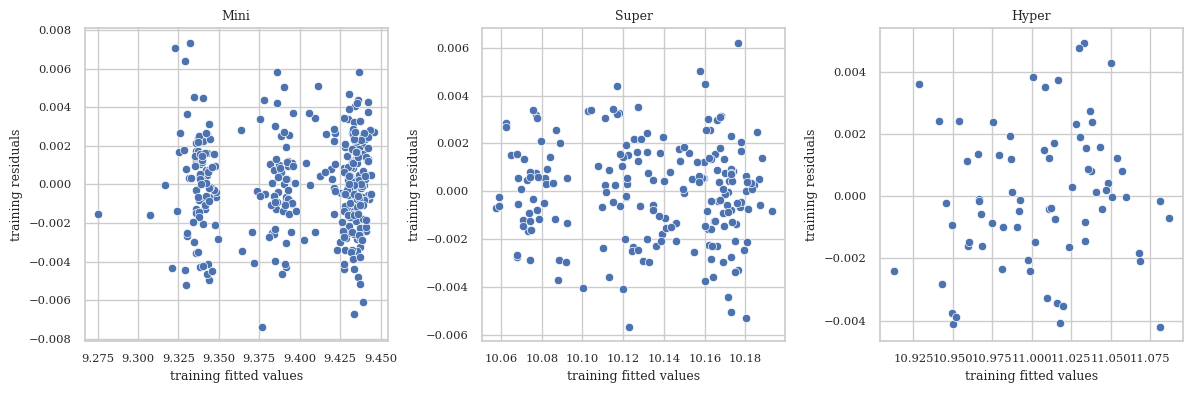

In [1712]:
# variance of error terms: residuals vs fitted values
_, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (12, 4))
index = 0
ax = ax.flatten()
for index in range(3):
	remove_indexes = list_index[:index] + list_index[(index + 1):]
	X_train_with_intercept_market = X_train_with_intercept.loc[X_train_with_intercept.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	residuals_training_market = residuals_training.loc[residuals_training.index.difference(remove_indexes[0]).difference(remove_indexes[1])]
	sns.scatterplot(x = model.predict(X_train_with_intercept_market), y = residuals_training_market, ax = ax[index])
	ax[index].set_title(list_names[index])
	ax[index].set_xlabel("training fitted values")
	ax[index].set_ylabel("training residuals")
	index = index + 1
plt.tight_layout()

In [1713]:
name = ["lagrange multiplier statistic", "p-value"]
test = sm.stats.het_breuschpagan(residuals_training, model.model.exog)
print("- lagrange multiplier statistic:", lzip(name, test)[0][1], "\n- p-value", lzip(name, test)[1][1])

- lagrange multiplier statistic: 12.186822556967037 
- p-value 0.09458008529952955


### collinearity

In [1714]:
# collinearity
vif = pd.DataFrame()
vif["VIF factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["feature"] = X_train.columns
vif

,VIF factor,feature
0,20.108845,square_feet
1,2.592391,is_mini
2,2.801661,is_hyper
3,2.094106,is_italy
4,3.015917,is_france
5,1.468730,competitor_distance
6,19.164319,avg_customers


### backward selection

## feature selection (lasso) (only log of the target)

## PCA

best number of components:
	- k = 9
errors:
	- RSE: 0.002481021618288206
	- R2: 0.9999811487267862
	- MSE: 5.75170261278571e-06


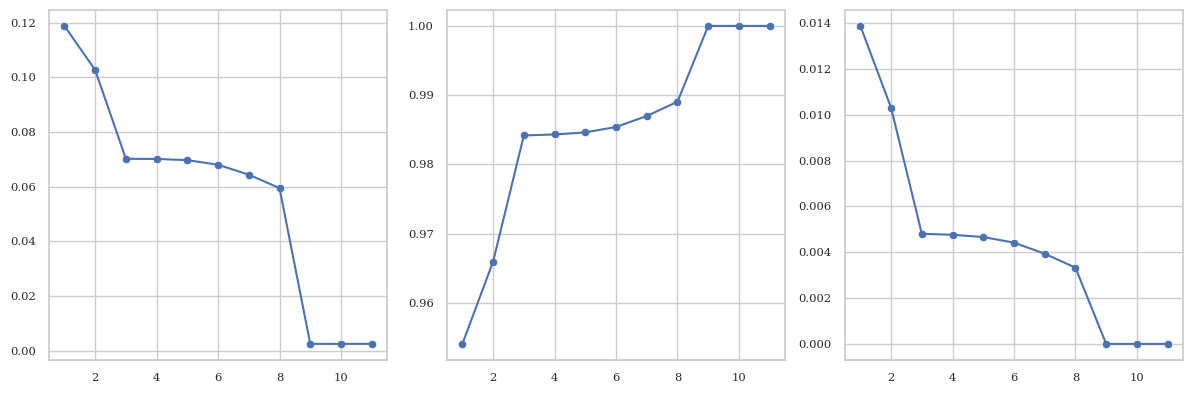

In [1718]:
# PCA
def pca_regression(X, y):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)

	# standardize features by removing the mean and scaling to unit variance
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)
	X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

	# initialize parameters
	p = X_scaled.shape[1]
	errors_pca_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	errors_pca = []
	for _ in range(p):
		errors_pca.append(errors_pca_k.copy())

	# for each number of principal components
	for k in range(1, p + 1):
		# transform using n_components for PCA
		pca = PCA(n_components = k)
		X_pca = pca.fit_transform(X_scaled)
		X_pca = pd.DataFrame(X_pca)
		# add a constant for the intercept term
		X_pca = sm.add_constant(X_pca)  
		# initialize empty array to store mse for each fold
		cv_folds = {
			"RSE": 0,
			"R2": 0,
			"MSE": 0,
			"len": 0
		}
		# for each fold fit the model
		for train_index, validation_index in kf.split(X_pca):
			X_train, X_validation = X_pca.iloc[train_index], X_pca.iloc[validation_index]
			y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
			model = sm.OLS(y_train, X_train).fit()
			y_pred = model.predict(X_validation)
			RSE, R2, MSE = calculate_metrics(y_validation, y_pred, X_train.shape[1])
			cv_folds["RSE"] = cv_folds["RSE"] + RSE
			cv_folds["R2"] = cv_folds["R2"] + R2
			cv_folds["MSE"] = cv_folds["MSE"] + MSE
			cv_folds["len"] = cv_folds["len"] + 1
		cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
		# save errors
		errors_pca[k - 1]["RSE"] = cv_folds["RSE"]
		errors_pca[k - 1]["R2"] = cv_folds["R2"]
		errors_pca[k - 1]["MSE"] = cv_folds["MSE"]
	return errors_pca

def report_best_components(errors_pca, criteria):
	p = len(errors_pca)
	criteria_list = [errors_pca[k][criteria] for k in range(p)]
	if (criteria == "RSE") or (criteria == "MSE"):
		criteria_best_k = criteria_list.index(min(criteria_list))
	elif (criteria == "R2"):
		criteria_best_k = criteria_list.index(max(criteria_list))
	print("best number of components:\n\t- k =", criteria_best_k + 1)
	print("errors:\n\t- RSE:", errors_pca[criteria_best_k]["RSE"])
	print("\t- R2:", errors_pca[criteria_best_k]["R2"])
	print("\t- MSE:", errors_pca[criteria_best_k]["MSE"])

# load the dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = np.log(merged_df["sales_amount"])

errors_pca = pca_regression(X, y)
report_best_components(errors_pca, "RSE")
plot_best_model(errors_pca)

## PLS

In [ ]:
# PCA
def pls_regression(X, y):
	# initialize kfold object to use for model evaluation
	number_folds = 5
	kf = KFold(n_splits = number_folds, shuffle = True, random_state = 0)

	# standardize features by removing the mean and scaling to unit variance
	scaler = StandardScaler()
	X_scaled = scaler.fit_transform(X)
	X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

	# initialize parameters
	p = X_scaled.shape[1]
	errors_pca_k = {
		"RSE": float("inf"),
		"R2": 0,
		"MSE": float("inf"),
	}
	errors_pca = []
	for _ in range(p):
		errors_pca.append(errors_pca_k.copy())

	# for each number of principal components
	for k in range(1, p + 1):
		# transform using n_components for PCA
		pls = PLSRegression(n_components = k) 
		# initialize empty array to store mse for each fold
		cv_folds = {
			"RSE": 0,
			"R2": 0,
			"MSE": 0,
			"len": 0
		}
		# for each fold fit the model
		for train_index, validation_index in kf.split(X_pca):
			X_train, X_validation = X_pca.iloc[train_index], X_pca.iloc[validation_index]
			y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
			pls.fit(X_train, y_train)
            y_pred = pls.predict(X_validation)
            y_pred = pd.Series([elem[0] for elem in y_pred])
            RSE, R2, MSE = calculate_metrics(y_validation.reset_index(drop = True), y_pred, X_train.shape[1]) 
            cv_folds["RSE"] = cv_folds["RSE"] + RSE
			cv_folds["R2"] = cv_folds["R2"] + R2
			cv_folds["MSE"] = cv_folds["MSE"] + MSE
			cv_folds["len"] = cv_folds["len"] + 1
		cv_folds = {key: cv_folds[key] / cv_folds["len"] for key in cv_folds.keys()}
		# save errors
		errors_pca[k - 1]["RSE"] = cv_folds["RSE"]
		errors_pca[k - 1]["R2"] = cv_folds["R2"]
		errors_pca[k - 1]["MSE"] = cv_folds["MSE"]
	return errors_pca

def report_best_components(errors_pca, criteria):
	p = len(errors_pca)
	criteria_list = [errors_pca[k][criteria] for k in range(p)]
	if (criteria == "RSE") or (criteria == "MSE"):
		criteria_best_k = criteria_list.index(min(criteria_list))
	elif (criteria == "R2"):
		criteria_best_k = criteria_list.index(max(criteria_list))
	print("best number of components:\n\t- k =", criteria_best_k + 1)
	print("errors:\n\t- RSE:", errors_pca[criteria_best_k]["RSE"])
	print("\t- R2:", errors_pca[criteria_best_k]["R2"])
	print("\t- MSE:", errors_pca[criteria_best_k]["MSE"])

# load the dataset
X = merged_df.loc[:, merged_df.columns != "sales_amount"]
y = np.log(merged_df["sales_amount"])

errors_pca = pca_regression(X, y)
report_best_components(errors_pca, "RSE")
plot_best_model(errors_pca)